<a href="https://colab.research.google.com/github/chw8207/fastai_pytorch/blob/main/%EB%AA%A8%EB%8D%B8%EC%97%90%EC%84%9C_%EC%A0%9C%ED%92%88%EA%B9%8C%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install azure-cognitiveservices-search-imagesearch

In [ ]:
pip install fastbook

In [4]:
import tensorflow as tf
import os
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth
import requests
import json
from re import L
from fastbook import *
from fastai.vision.widgets import *

### GPU 설정

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0' :
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [6]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4959902982223754642
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40129593344
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17056399321092395947
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


### 데이터 수집
- 빙 이미지 검색 사용

#### search_images_bing 함수

In [7]:
def search_images_bing(key, term, min_sz=128, max_images=150) :
  params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
  headers = {'Ocp-Apim-Subscription-Key':key}
  search_url = 'https://api.bing.microsoft.com/v7.0/images/search'
  response = requests.get(search_url, headers=headers, params=params)
  response.raise_for_status()
  search_results = response.json()
  return L(search_results['value'])

In [8]:
key = os.environ.get('AZURE_SEARCH_KEY', '9d1022eee0e24c89bb8ef2dda2583142')

In [9]:
search_images_bing

<function __main__.search_images_bing(key, term, min_sz=128, max_images=150)>

In [10]:
# 함수 사용해 보기
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [11]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

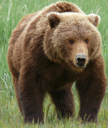

In [12]:
# 회색곰 이미지 다운로드하고 확인해보기
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128,128)

In [13]:
# 각 검색어에서 얻은 모든 ULR의 이미지를
# download_images 함수로 다운로드하기
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [14]:
bear_types

('grizzly', 'black', 'teddy')

In [15]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [16]:
fns = get_image_files(path)
fns

(#428) [Path('bears/grizzly/90a46ad5-407c-4c15-ab04-ad247b613928.jpg'),Path('bears/grizzly/34461230-7b7a-4417-a445-868b5aa5b01e.jpg'),Path('bears/grizzly/efa16c53-3661-46fd-8e2c-f3af5fb6f21a.jpg'),Path('bears/grizzly/70abffff-086f-4ba5-907e-494d3f9584ff.jpg'),Path('bears/grizzly/0c87f509-a1b8-48fc-a68d-17277c09919f.jpg'),Path('bears/grizzly/155106b8-36d9-4199-8068-bea8cb328afd.jpg'),Path('bears/grizzly/e25899c3-dc5b-45bc-8368-9733a82de128.jpg'),Path('bears/grizzly/61be4608-7e15-4a67-9ebf-5797f9347a67.jpg'),Path('bears/grizzly/5f2d16f8-385a-4dad-b74b-98116f0aefcf.jpg'),Path('bears/grizzly/eb594932-e8ed-4005-8c80-0faa4e3a24dd.jpg')...]

In [17]:
# 파일 오류여부 검사
failed = verify_images(fns)
failed

(#22) [Path('bears/grizzly/61be4608-7e15-4a67-9ebf-5797f9347a67.jpg'),Path('bears/grizzly/b158e4e9-5ff0-4b91-b883-a0e5dca32332.jpg'),Path('bears/grizzly/3711a558-1ccb-4781-887c-0788069e6ad7.jpg'),Path('bears/grizzly/1920a14f-68ed-4a6b-9346-a703dbb18e87.jpg'),Path('bears/black/ca63f2bd-0772-4521-ba67-01f278d9faae.jpg'),Path('bears/black/3ade3d6d-55f1-411e-94d7-4cb002f93bbb.jpg'),Path('bears/black/0168a288-ad7f-428e-83b2-ac20791846af.jpg'),Path('bears/black/aa4f2141-38b6-4e05-bf04-510602a09cbe.jpg'),Path('bears/black/14cfe7a7-22e2-4b3d-8239-11531a8e64d2.jpg'),Path('bears/teddy/f6b35d18-89a3-4316-9082-910e66544522.jpg')...]

In [18]:
# 오류가 발생한 모든 파일 삭제
failed.map(Path.unlink);

In [19]:
# ??verify_images

### DataLoaders

In [ ]:
# DataLoaders의 주요 기능 코드
'''
class DataLoaders(GetAttr) :
  def __init__(self, *loaders) :
    self.loaders = loaders
  def __getitem__(self, i) :
    return self.loaders[i]
    train,valid = add_probs(lambda i,self : self[i])
'''

In [21]:
# 데이터블록 API를 사용하여 다운로드한 데이터셋을 DataLoaders로 만들기
bears = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  get_y=parent_label,
                  item_tfms=Resize(128))

In [22]:
dls = bears.dataloaders(path)

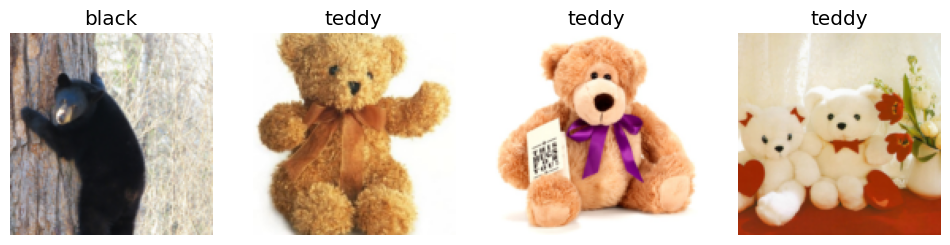

In [23]:
# show_batch : 하나의 배치 요소 중 일부를 화면에 출력함
dls.valid.show_batch(max_n=4, nrows=1)